## 멀티 에이전트 슈퍼바이저(Multi-agent supervisor)

Supervisor agent는 여러 하위 에이전트들의 작업을 조율하고 관리하며, 작업을 적절한 에이전트에게 분배하고 전체 워크플로우를 감독하는 상위 레벨의 AI 에이전트입니다.

- 관련 자료: https://wikidocs.net/270690

## 환경 설정

In [1]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

## 상태 정의

In [1]:
from typing import Annotated
from langgraph.graph.message import MessagesState


class State(MessagesState):
    next_agent: Annotated[str, "다음 작업자"]

## 도구 정의

In [2]:
from langchain_core.tools import Tool
from langchain_tavily import TavilySearch
from langchain_experimental.utilities import PythonREPL

web_search_tool = TavilySearch(max_results=3)

python_repl = PythonREPL()
python_repl_tool = Tool(
    "python_repl",
    description="파이썬 Shell입니다. 파이썬 명령어를 실행하는 데 사용하세요. 입력은 유효한 파이썬 명령어여야 합니다. 값의 출력을 확인하려면 `print(...)`로 출력해야 합니다.",
    func=python_repl.run,
)

## Research Agent

In [ ]:
from langgraph.prebuilt import create_react_agent
from typing import Literal

research_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[web_search_tool],
    prompt=(
        "귀하는 연구 에이전트입니다.\n\n"
        "INSTRUCTIONS:\n"
        "- 연구 관련 작업만 지원하며, 어떠한 수학 연산도 수행하지 마십시오\n"
        "- 작업을 마치면 감독관에게 직접 응답하십시오\n"
        "- 작업 결과만 응답하고, 그 외의 텍스트는 포함하지 마십시오."
    ),
    name="research_agent",
)


def research_node(state: State):
    response = research_agent.invoke({"messages": state["messages"]})
    message = response["messages"][-1].content
    return {"messages": [("user", message)]}

In [31]:
research_node({"messages": [("user", "웹에서 랭그래프를 조사하여 알려주세요.")]})

{'messages': [('user',
   '랭그래프(LangGraph)는 복잡한 멀티 에이전트 시스템 및 AI 워크플로우 개발에 특화된 프레임워크입니다. 주로 LLM(대형 언어 모델)를 활용하여 상태(State)를 유지하고, 여러 에이전트가 협업하는 구조를 그래프 형태(노드와 엣지)로 설계·실행할 수 있게 해줍니다. 워크플로를 시각적으로 표현 및 관리할 수 있으며, 조건 분기, 루프 등 복잡한 로직을 손쉽게 구현할 수 있습니다. 예시로 챗봇의 상태관리, 마케팅 캠페인 자동화, 복잡한 정보 검색 엔진 등에서 활용됩니다.\n\n출처: \n- https://ai-inform.tistory.com/entry/%EB%9E%AD%EA%B7%B8%EB%9E%98%ED%94%84%EB%9E%80-LangGraph-%EC%89%AC%EC%9A%B4%EC%84%A4%EB%AA%85\n- https://brunch.co.kr/@wikibook/63\n- https://code-jong10.tistory.com/111')]}

## Coder Agent

In [32]:
coder_prompt = """귀하는 코드 에이전트입니다. 

INSTRUCTIONS:
- 코드 관련 작업에만 도움을 주십시오.
- 작업 완료 후에는 감독관에게 직접 응답하십시오.
- 작업 결과만 답변하고, 그 외 어떤 내용도 포함하지 마십시오.

시각화를 위해 코드에서 반드시 다음과 같이 한글 폰트를 사용하십시오.

```python
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False
```"""

coder_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[python_repl_tool],
    prompt=coder_prompt,
    name="coder_agent",
)


def coder_node(state: State):
    response = research_agent.invoke({"messages": state["messages"]})
    message = response["messages"][-1].content
    return {"messages": [("user", message)]}

## Supervisor Agent

In [33]:
from langchain_openai import ChatOpenAI
from langgraph.graph import END
from pydantic import BaseModel

supervisor_prompt = """당신은 다음 작업자들을 관리하는 감독관입니다: research, coder 
사용자 요청이 주어졌을 때, 다음에 행동할 작업자를 응답합니다. 
각 작업자는 작업을 수행하고 결과 및 상태를 응답합니다. 
모든 작업을 완료하면, FINISH로 응답하세요."""


class SupervisorResponse(BaseModel):
    """다음 작업자를 선택하거나 작업 완료를 응답합니다."""

    next_agent: Literal["research", "coder", "FINISH"]


supervisor_model = ChatOpenAI(model="gpt-5-mini").with_structured_output(
    SupervisorResponse
)


def supervisor_agent(state: State) -> Literal["research", "coder", "FINISH"]:
    response = supervisor_model.invoke(
        [("system", supervisor_prompt)] + state["messages"]
    )
    return response.next_agent

In [20]:
supervisor_agent({"messages": [("user", "웹에서 랭그래프를 조사하여 알려주세요.")]})

'research'

## 그래프 작성

In [34]:
from langgraph.graph import StateGraph


def router(state: State):
    if state["next_agent"] == "FINISH":
        return END
    else:
        return state["next_agent"]


builder = StateGraph(State)
builder.add_node("supervisor", supervisor_agent)
builder.add_node("research", research_node)
builder.add_node("coder", coder_node)

builder.add_conditional_edges("supervisor", router)
builder.add_edge("research", "supervisor")
builder.add_edge("coder", "supervisor")

builder.set_entry_point("supervisor")
graph = builder.compile()


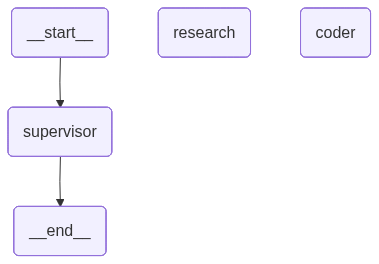

In [35]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
query = "2010년 ~ 2024년까지의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요."
for chunk in graph.stream({"messages": [("user", query)]}):
    for key, values in chunk.items():
        print(f"##### {key.upper()} #####")
        if values and "messages" in values:
            values["messages"][-1].pretty_print()

##### SUPERVISOR #####


ParentCommand: Command(update={'messages': [HumanMessage(content='2010년 ~ 2024년까지의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요.', additional_kwargs={}, response_metadata={}, id='791f2643-66d0-4e1c-8f63-46af4d5174c6'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_o6EJKTTRea2Ts1dgWepOLE6n', 'function': {'arguments': '{"query":"2010년부터 2024년까지 대한민국 1인당 GDP 추이 그래프","search_depth":"advanced"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 1362, 'total_tokens': 1401, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_daf5fcc80a', 'id': 'chatcmpl-CPfm077gp7HWdr8FOuOI3omqTyRmN', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='research_agent', id='run--158119af-a47e-4c11-8228-bc9d5c586d1b-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': '2010년부터 2024년까지 대한민국 1인당 GDP 추이 그래프', 'search_depth': 'advanced'}, 'id': 'call_o6EJKTTRea2Ts1dgWepOLE6n', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1362, 'output_tokens': 39, 'total_tokens': 1401, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), ToolMessage(content='{"query": "2010년부터 2024년까지 대한민국 1인당 GDP 추이 그래프", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://namu.wiki/w/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD/GDP", "title": "대한민국/GDP - 나무위키", "content": "#### 2.2.2.1인당 GDP(\\n\\n(단위: 달러)\\n\\n국가2017년2018년2019년 추정2020년 추정2021년 추정2022년 추정2023년 추정2024년 추정\\n대한민국29,75031,34631,93733,49135,03036,75238,61240,631\\n\\n다른 국가와의 비교\\n\\n [ 펼치기 · 접기 ] [...] #### 2.3.2.1인당 GDP(\\n\\n(단위: 달러)\\n\\n국가2016년2017년2018년 추정2019년 추정2020년 추정2021년 추정2022년 추정2023년 추정\\n대한민국27,60829,93832,04632,76634,20935,65837,31538,969\\n\\n다른 국가와의 비교\\n\\n [ 펼치기 · 접기 ] [...] 2024년 기준 1인당 GDP가 4만불이 넘을 것으로 예상되는 주요국의 IMF 추산 1인당 GDP 예측치이다. 2019년에는 강달러와 원화 약세를 예상했는지 2.6%의 성장률을 예측했음에도 1인당 GDP는 2018년과 거의 변함이 없는 것으로 예측하고 있다.\\n\\n### 2.3.2018년(\\n\\n#### 2.3.1.총액 GDP(\\n\\n(단위: 10억 달러, %)\\n\\n국가2016년2017년2018년 추정2019년 추정2020년 추정2021년 추정2022년 추정2023년 추정\\n대한민국1,414.801,540.461,655.611,699.681,781.771,864.791,959.372,054.56\\n3.03.12.82.62.82.82.72.6\\n\\n다른 국가와의 비교\\n\\n [ 펼치기 · 접기 ]", "score": 0.8524574, "raw_content": null}, {"url": "https://www.index.go.kr/unify/idx-info.do?idxCd=5001", "title": "국내총생산 - 국가지표체계 | 지표상세정보", "content": "한국 경제의 GDP는 꾸준히 증가하여 2010년에 1,000조 원을 넘었고 2012년에 미 달러화 기준 1조 달러를 넘어섰다. 세계은행(World Bank)이 발표한 GDP 순위에 의하면 한국은 2000년대 들어 15위권을 유지하고 있다. 한국의 실질 GDP 규모는 2024년 현재 약 2,292조 원에 달한다. 이를 1인당 금액으로 계산하면 약 4,429만 원에 해당한다. 통상 가계소득으로 유추되는 1인당 소득에 비해 1인당 GDP가 훨씬 더 높은 이유는 가계소득에는 GDP에 들어 있는 감가상각, 법인세와 간접세, 기업이윤 등이 포함되지 않기 때문이다.\\n\\n### 관련용어\\n\\n명목GDP\\n\\n국내총생산은 어느 해의 시장가격을 이용하여 생산액을 평가하느냐에 따라 명목 GDP와 실질 GDP로 구분되는데, 명목 GDP는 당해 연도 생산량에 당해 연도 시장가격을 곱하여 산출하기 때문에 물가상승분이 반영된 값으로, 국민 경제의 전체적인 규모나 산업 구조를 파악할 때 활용.\\n\\n감가상각 [...] 실질 국내총생산\\n\\n출처 : 한국은행, 「국민계정」\\n\\n ＊자료 : 한국은행, 「국민계정」 각 연도\\n\\n주석 : 1) 실질 국내총생산은 2020년 불변가격 기준임.\\n\\n2) 2024년은 잠정치임.\\n\\n### 통계표\\n\\n통계명 \\n\\n기간선택 통계표시작시점  ~ 통계표종료시점 \\n\\n조회;)\\n\\n### 정의\\n\\n 한 국가 내의 모든 경제주체가 1년 동안 생산한 최종재의 시장가치를 모두 더한 것임. 명목 GDP는 당해 연도 생산량에 당해 연도 시장가격을 곱하여 산출하고, 실질 GDP는 당해 연도 생산량에 기준 연도 가격을 곱하여 산출함. \\n\\n### 해설", "score": 0.82560414, "raw_content": null}, {"url": "https://data.worldbank.org/country/KR?locale=ko", "title": "대한민국 | Data", "content": "(2024)\\n\\n0.1\\n\\n(2024)\\n\\nTrend\\n\\n순인구이동\\n\\n순인구이동\\n\\nMost recent value\\n\\n(2024)\\n\\n75,963\\n\\n(2024)\\n\\nTrend\\n\\nHuman Capital Index (HCI) (scale 0-1)\\n\\nHuman Capital Index (HCI) (scale 0-1)\\n\\nMost recent value\\n\\n(2020)\\n\\n0.799\\n\\n(2020)\\n\\nTrend\\n\\n## Economic\\n\\nIndicator\\n\\nMost recent value\\n\\nTrend\\n\\nGDP (현재 US$)\\n\\nGDP (현재 US$)\\n\\nMost recent value\\n\\n(2023 조)\\n\\n1.71\\n\\n(2023 조)\\n\\nTrend\\n\\n1인당 GDP (현재 US$)\\n\\n1인당 GDP (현재 US$)\\n\\nMost recent value\\n\\n(2023)\\n\\n33,121.4\\n\\n(2023)\\n\\nTrend\\n\\nGDP성장률 (연간 %)\\n\\nGDP성장률 (연간 %)\\n\\nMost recent value\\n\\n(2023)\\n\\n1.4", "score": 0.70871735, "raw_content": null}], "response_time": 1.57, "request_id": "eac5514a-ca70-4b11-95ff-1ca76f6d7c50"}', name='tavily_search', id='5417581c-0901-4f47-99da-e95a49af9aea', tool_call_id='call_o6EJKTTRea2Ts1dgWepOLE6n'), AIMessage(content='- 2010년부터 2024년까지 대한민국 1인당 GDP 추이에 관한 연도별 데이터와 그래프는 다음 출처에서 확인할 수 있습니다:\n  - [나무위키: 대한민국/GDP](https://namu.wiki/w/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD/GDP) (표로 연도별 추이 및 2024년 IMF 추정치 수록)\n  - [국가지표체계: 국내총생산](https://www.index.go.kr/unify/idx-info.do?idxCd=5001) (한국은행 데이터 기반 공식 통계 확인 가능)\n  - [월드뱅크 데이터포털 - 대한민국](https://data.worldbank.org/country/KR?locale=ko) (연간 1인당 GDP 값 그래프로 제공)\n\n이 링크에서 그래프와 연도별 수치 데이터를 시각적으로 확인할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 213, 'prompt_tokens': 2899, 'total_tokens': 3112, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1280}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_daf5fcc80a', 'id': 'chatcmpl-CPfm3fJhV4bsZUKsXRVRVQ9r2rLj0', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='research_agent', id='run--9166720e-0e78-4bd2-aece-0ca245581eed-0', usage_metadata={'input_tokens': 2899, 'output_tokens': 213, 'total_tokens': 3112, 'input_token_details': {'audio': 0, 'cache_read': 1280}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}, goto='supervisor')